In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random

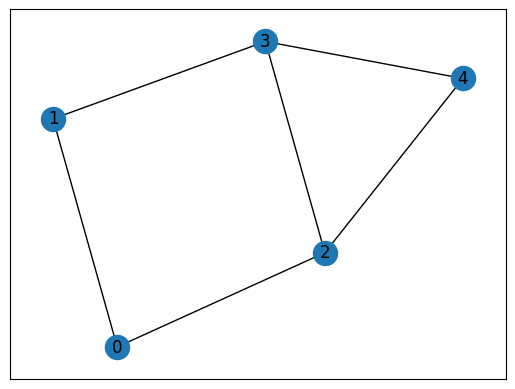

In [2]:
G = nx.house_graph()
nx.draw_networkx(G)

In [3]:
adj_matrix = nx.adjacency_matrix(G).todense()
degrees    = np.array(adj_matrix).sum(axis=0)
deg_matrix = np.diag(degrees)
lap_matrix = deg_matrix - adj_matrix

print('Adjacency Matrix (A)')
print(adj_matrix)
print()

print('Degree Matrix (D)')
print(deg_matrix)
print()

print('Laplacian Matrix (D-A)')
print(lap_matrix)
print()

Adjacency Matrix (A)
[[0 1 1 0 0]
 [1 0 0 1 0]
 [1 0 0 1 1]
 [0 1 1 0 1]
 [0 0 1 1 0]]

Degree Matrix (D)
[[2 0 0 0 0]
 [0 2 0 0 0]
 [0 0 3 0 0]
 [0 0 0 3 0]
 [0 0 0 0 2]]

Laplacian Matrix (D-A)
[[ 2 -1 -1  0  0]
 [-1  2  0 -1  0]
 [-1  0  3 -1 -1]
 [ 0 -1 -1  3 -1]
 [ 0  0 -1 -1  2]]



In [4]:
# same result from using nx's implementation
nx.laplacian_matrix(G).toarray()

array([[ 2, -1, -1,  0,  0],
       [-1,  2,  0, -1,  0],
       [-1,  0,  3, -1, -1],
       [ 0, -1, -1,  3, -1],
       [ 0,  0, -1, -1,  2]])

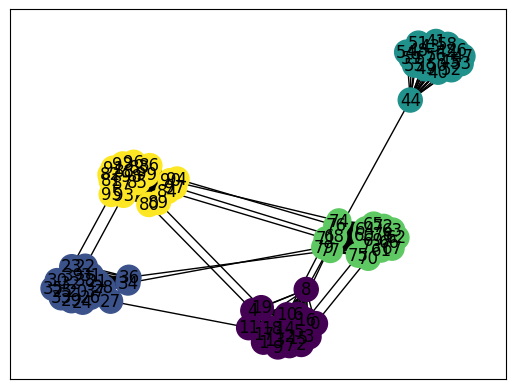

In [187]:
# generate a network with clear clusters
CLUSTER_SIZE = 20
NUM_CLUSTERS = 5
CONNECTIVITY = 0.005

clusters   = [nx.complete_graph(CLUSTER_SIZE) for _ in range(NUM_CLUSTERS)]
G          = nx.disjoint_union_all(clusters)
num_points = CLUSTER_SIZE * NUM_CLUSTERS

# TODO: optimise using some np implementation
for p1 in range(num_points):
    for p2 in range(p1+1, num_points):
        c1 = p1 % CLUSTER_SIZE
        c2 = p2 % CLUSTER_SIZE
        if c1 == c2: continue

        if random.uniform(0, 100) >= CONNECTIVITY * 100: continue
        G.add_edge(p1, p2)
    
ground_truth = np.zeros((num_points))
for i in range(NUM_CLUSTERS):
    ground_truth[i*CLUSTER_SIZE:(i+1)*CLUSTER_SIZE] = i
ground_truth
nx.draw_networkx(G, ax=plt.axes(), with_labels=True, node_color = ground_truth)

In [188]:
# extract its laplacian, calculate its eigenvectors and values
lap = nx.laplacian_matrix(G).todense()
eig_val, eig_vec = np.linalg.eig(lap)

eig_val = eig_val.real
eig_vec = eig_vec.real

print('Eigenvalues')
eig_val[:10]

Eigenvalues


array([ 2.28159577e+01,  6.44608036e-01,  4.76770347e-01, -9.00519582e-15,
        3.07251537e-01,  5.17771608e-02,  2.20000000e+01,  2.15375700e+01,
        2.08553223e+01,  2.19499781e+01])

In [189]:
# view the sorted eigenvalues (just first 10)

N = G.number_of_nodes()
sorted(eig_val)[:10]

[-9.00519581943054e-15,
 0.05177716083692895,
 0.30725153727707916,
 0.47677034664217444,
 0.6446080360180532,
 19.999999999999954,
 19.999999999999964,
 19.999999999999968,
 19.999999999999968,
 19.99999999999998]

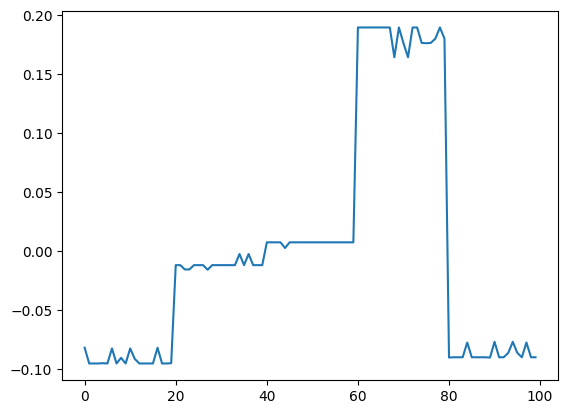

In [190]:
# there seems to be a strong cutoff at 10
# calculate the fiedler eigenvector as a measure of graph connectivity

i = np.where(eig_val<10)[0]
plt.plot(eig_vec[:,i[0]])

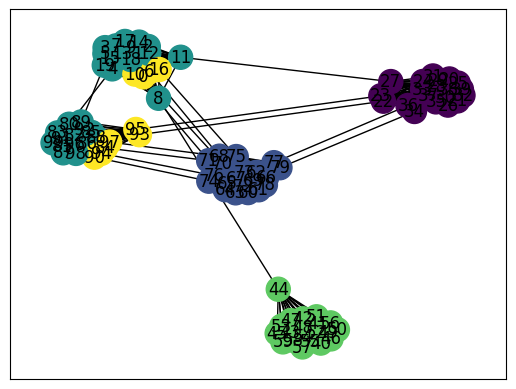

In [191]:
from sklearn.cluster import KMeans

# get rid of the complex part of Fiedler eigenvector
real_values = np.array(eig_vec[:,i[0]], dtype=np.float64).reshape(-1, 1)

# train a KMeans Clustering Model on the Fiedler eigenvector
kmeans_model = KMeans(n_clusters=NUM_CLUSTERS).fit(real_values)
cluster_labels = kmeans_model.labels_
nx.draw_networkx(G, node_color=cluster_labels)

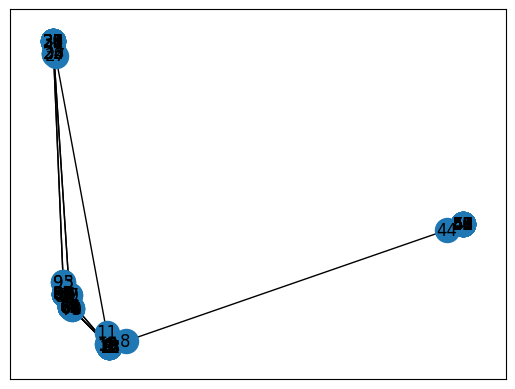

In [192]:
nx.draw_networkx(G, pos=nx.spectral_layout(G))

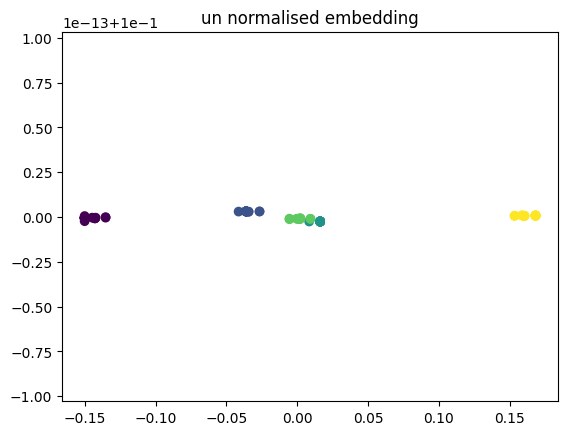

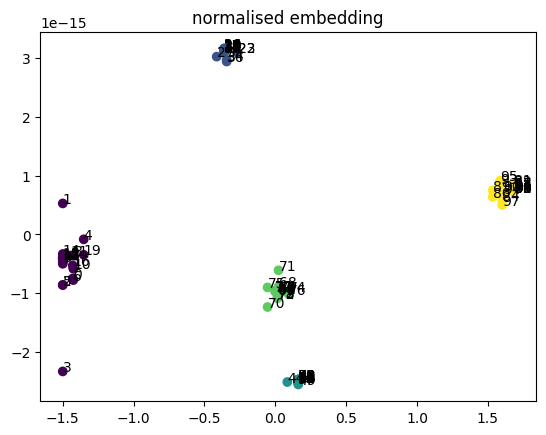

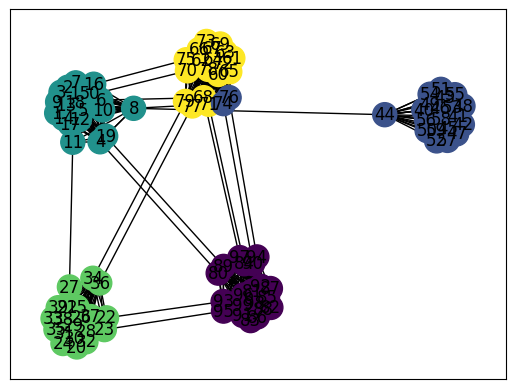

In [195]:
# now, let's try again but take more than one vector, let's take the second and third most important vectors
test = eig_vec[:,i[1:3]]
plt.scatter(test[:,0], test[:,1], c=ground_truth)
plt.title('un normalised embedding')
plt.show()

# lets try to normalise this embedding, and see the difference
from sklearn import preprocessing
scaled = preprocessing.StandardScaler().fit_transform(test)
plt.scatter(scaled[:,0], scaled[:,1], c=ground_truth)
for ind in range(num_points):
    plt.text(scaled[:,0][ind], scaled[:,1][ind], ind)
plt.title('normalised embedding')
plt.show()


# lets run k-means on this normalised embedding instead
from sklearn.cluster import KMeans
# get rid of the complex part of Fiedler eigenvector
real_values = np.array(scaled, dtype=np.float64)
# train a KMeans Clustering Model on the Fiedler eigenvector
kmeans_model = KMeans(n_clusters=NUM_CLUSTERS).fit(real_values)
cluster_labels = kmeans_model.labels_
nx.draw_networkx(G, node_color=cluster_labels)
plt.show()